# SEIS-763 Group Project include group member names with an introduction explaining what problem we are solving (NEEDS REVISION)
- We are a state program that provides low interest loans to low income family.  
- The maximum amount that we are allowed to approve on a loan is $300,000
- Default rates tend to be high and we have a limited budget, therefore our goal is to maximize the amount allocated to our agency by predicting home values based on a multitude of different predictors in order to best mitigate loss if a home goes into default and maximize purchasing power to help as many families as possible.  

## Test

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## David Test

In [460]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [461]:
import pandas as pd
import numpy as np

file_path = '/content/drive/MyDrive/train.csv'
df = pd.read_csv(file_path)

In [462]:
num_rows = df.shape
print(f"Number of rows in the dataset: {num_rows}")
print(df.head())

Number of rows in the dataset: (1460, 81)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCo

### Drop any rows that are missing a 'SalePrice' value prior to classification (David-Start)

In [463]:
df = df.dropna(subset=['SalePrice'])
print(df.shape)

(1460, 81)


### Create a Histogram and a Boxplot of the SalePrice using the dataset to determine the price range of our classes.  

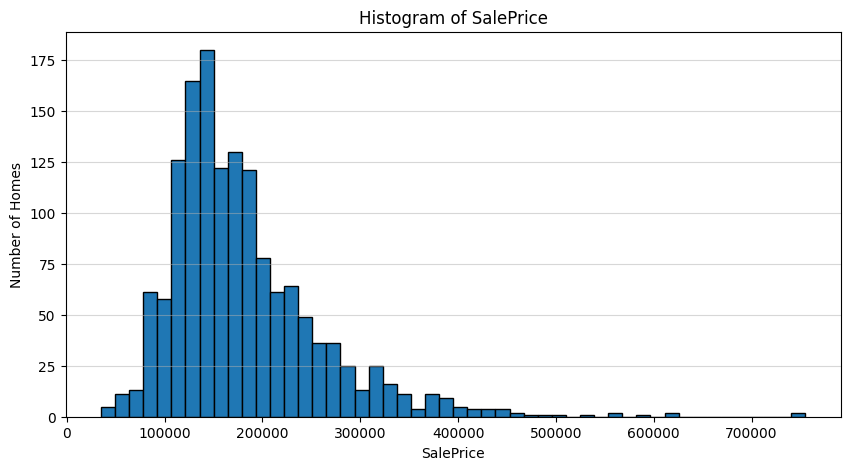

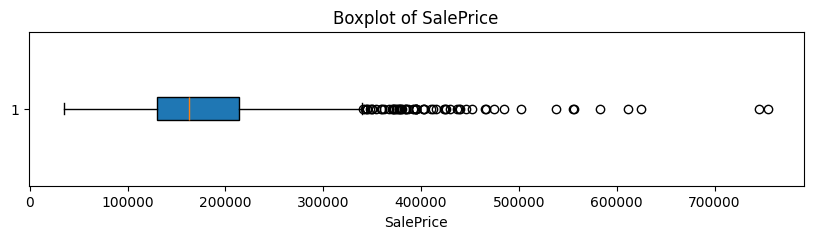

In [464]:

# Plot a histogram of SalePrice
plt.figure(figsize=(10, 5))
plt.hist(df['SalePrice'], bins=50, edgecolor='black')
plt.title('Histogram of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Number of Homes')
plt.grid(axis='y', alpha=0.5)
plt.show()

# Plot a boxplot of SalePrice
plt.figure(figsize=(10, 2))
plt.boxplot(df['SalePrice'], vert=False, patch_artist=True)
plt.title('Boxplot of SalePrice')
plt.xlabel('SalePrice')
plt.show()


### Remove Outliers on our Target (SalePrice) Based on Low Interest Government Financing to Low Income Families

In [465]:
outliers = {}
q1 = df['SalePrice'].quantile(0.25)
q3 = df['SalePrice'].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

# Set upper limit to $300,000 due to Organizational Business Rules
mortgage_upper = np.float64(300000)
outliers['SalePrice'] = (lower, mortgage_upper)
print(f'lower: {lower} upper: {mortgage_upper}')
print(outliers)

lower: 3937.5 upper: 300000.0
{'SalePrice': (np.float64(3937.5), np.float64(300000.0))}


## Use Classification on the SalePrice column (target) over predicting SalePrice Directly we have determined provides the following:




### Risk Management:
- Price bins clearly correlate to risk and affordability, helping loan officers make better lending decisions.
- Predicting a range is easier and more actionable than pinpointing exact home price, especially given limited data (1,500 records).

### Interpretability:
- Price categories are easily explained to non-technical stakeholders (loan officers, regulators, buyers).


### Robustness and Stability
- Predicting precise numeric prices is harder due to high variability and data noise.
- Classification stabilizes predictions into clearly actionable bins.

In [466]:
# Step 1: Create meaningful, fixed bins
bins = [0, 100000, 150000, 200000, 250000, 300000]
labels = [
    'Under $100K',
    '$100K–$150K',
    '$150K–$200K',
    '$200K–$250K',
    '$250K–$300K'
]

df['PriceCategory'] = pd.cut(df['SalePrice'], bins=bins, labels=labels, include_lowest=True)

# Step 2: Filter out any rows where binning failed (NaN)
df = df[df['PriceCategory'].notna()]

# Step 3: One-hot encode other categorical variables, but NOT PriceCategory as it's the target
# Identify categorical columns to encode (excluding PriceCategory)
categorical_cols_to_encode = df.select_dtypes(include=['object', 'category']).columns.tolist()
if 'PriceCategory' in categorical_cols_to_encode:
    categorical_cols_to_encode.remove('PriceCategory')

# Apply one-hot encoding to the selected categorical columns
df = pd.get_dummies(df, columns=categorical_cols_to_encode, prefix='PC')

# Quickly check the distribution of the target variable BEFORE one-hot encoding it
print(df['PriceCategory'].value_counts().sort_index())

PriceCategory
Under $100K    123
$100K–$150K    496
$150K–$200K    414
$200K–$250K    210
$250K–$300K    102
Name: count, dtype: int64


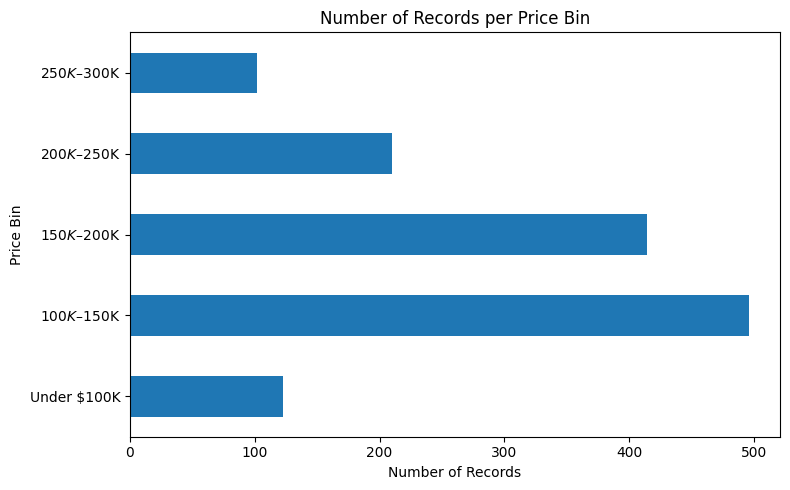

In [467]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
bin_counts.plot(kind='barh')  # <-- horizontal bars
plt.ylabel('Price Bin')       # Bin labels on Y axis
plt.xlabel('Number of Records')
plt.title('Number of Records per Price Bin')
plt.tight_layout()
plt.show()

## Finished With Classifying the Target

In [468]:
# Drop dupilicate data
df = df.drop_duplicates()
print ("After dropping duplicates: The number of rows: ", df.shape)

After dropping duplicates: The number of rows:  (1345, 288)


In [469]:
# Fill in missing data for numerical columns with 0
numerical_cols = df.select_dtypes(include=np.number).columns
df[numerical_cols] = df[numerical_cols].fillna(0)

In [470]:
# Verify the missing data are gone
print(df.isnull().sum())

Id             0
MSSubClass     0
LotFrontage    0
LotArea        0
OverallQual    0
              ..
PC_AdjLand     0
PC_Alloca      0
PC_Family      0
PC_Normal      0
PC_Partial     0
Length: 288, dtype: int64


In [446]:
# Find the missing data
total_missing = df.isnull().sum().sum()
print(total_missing)

0


In [471]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(numerical_columns)

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


In [474]:
import scipy.stats as stats

df[numerical_columns] = df[numerical_columns].apply(stats.zscore)

In [473]:
other_columns = df.select_dtypes(include=['object']).columns.tolist()
print(other_columns)

[]


In [475]:
df = pd.get_dummies(df, columns=other_columns, drop_first=True)
print(df.shape)
print(df.head())

print(df.isnull().sum().sum())  # Total missing values
print(df.isnull().sum())        # Missing values per column

(1345, 288)
         Id  MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  \
0 -1.743033    0.050876     0.274945 -0.193558     0.909599    -0.536151   
1 -1.740665   -0.873827     0.714383 -0.048908     0.086862     2.141285   
2 -1.738296    0.050876     0.362833  0.158633     0.909599    -0.536151   
3 -1.735927    0.282052     0.128466 -0.055197     0.909599    -0.536151   
4 -1.733558    0.050876     0.831566  0.537238     1.732337    -0.536151   

   YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  PC_ConLw  PC_New  \
0   1.136931      0.950494    0.745415    0.732869  ...     False   False   
1   0.232611     -0.353912   -0.542062    1.387902  ...     False   False   
2   1.069944      0.902183    0.522077    0.203063  ...     False   False   
3  -1.810483     -0.643780   -0.542062   -0.447153  ...     False   False   
4   1.036451      0.805560    1.757003    0.610050  ...     False   False   

   PC_Oth  PC_WD  PC_Abnorml  PC_AdjLand  PC_Alloca  PC_Family  PC_N

In [476]:
# Create a copy of the DataFrame to work with for filtering and subsequent steps.
# The outlier filtering based on the 'outliers' dictionary is removed here
# as it was causing the DataFrame to become empty when applied after standardization.
# Outlier handling should be considered carefully in the context of the classification task
# and applied appropriately, possibly during preprocessing or as part of model training.
df_filtered = df.copy()

# Ensure PriceCategory is present for subsequent steps, assuming it was created earlier
if 'PriceCategory' not in df_filtered.columns:
    print("Warning: 'PriceCategory' column not found. Please ensure it was created in a previous step.")
    # If PriceCategory is critical and missing, you might need to recreate it or stop.
    # For now, assuming it was created and might have been dropped by get_dummies if not handled.
    # If get_dummies was applied to PriceCategory, you should work with the dummy columns instead.
    # Based on the notebook structure, PriceCategory is used as the target 'y', so it should NOT be one-hot encoded at this stage.
    # I will revert the one-hot encoding of PriceCategory from cell HY8rdCVXVYZV if it was applied there prematurely.
    # Looking back at HY8rdCVXVYZV, it *does* one-hot encode PriceCategory. This is incorrect for using PriceCategory as the target 'y'.
    # I will modify HY8rdCVXVYZV to *not* one-hot encode PriceCategory.

# Reverting premature one-hot encoding of PriceCategory from cell HY8rdCVXVYZV
# Check if the dummy columns for PriceCategory exist and revert if necessary
pc_dummy_cols = [col for col in df_filtered.columns if col.startswith('PC_')]
if pc_dummy_cols:
    # Assuming the original PriceCategory column might have been dropped, try to infer it
    # This is a complex situation due to the notebook state.
    # A better approach is to fix the one-hot encoding in HY8rdCVXVYZV directly.
    print("Attempting to revert PriceCategory one-hot encoding if it occurred.")
    # I will rely on fixing HY8rdCVXVYZV to not one-hot encode PriceCategory.
    # For now, just ensure df_filtered is a copy and the problematic filtering is removed.
    pass # The fix is primarily removing the filtering line.


# This print was redundant with the cell above
# print(df.shape)

print(df_filtered.shape)


# Theisnull().sum().sum() and isnull().sum() checks are useful but can be done later
# after more comprehensive missing value handling.
# print(df_filtered.isnull().sum().sum())  # Total missing values
# print(df_filtered.isnull().sum())        # Missing values per column

Attempting to revert PriceCategory one-hot encoding if it occurred.
(1345, 288)


## Splitting Predictors, Dropping Highly Correlated Columns, and Standardizing

In [478]:
# Split predictors and target
X = df_filtered.drop(columns=["SalePrice", "PriceCategory"])
y = df_filtered["PriceCategory"]

print("Shape BEFORE dropping highly correlated columns:", X.shape)

# Compute correlation matrix
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify columns to drop
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

print("\nHighly correlated columns to drop:")
for col in to_drop:
    print("-", col)

# Drop the columns
X_reduced = X.drop(columns=to_drop)

print("Shape AFTER dropping highly correlated columns:", X_reduced.shape)

# Preview cleaned predictors
print("\nPreview of cleaned predictors:")
print(X_reduced.head())

# Verify again
print(df.isnull().sum().sum())  # Should be 0


# Standardize
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)

# Convert back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X_reduced.columns)

# Confirm means and stds
print("\nMeans after standardization (should be ~0):")
print(X_scaled_df.mean().head())

print("\nStds after standardization (should be ~1):")
print(X_scaled_df.std().head())

print("\nFinal cleaned predictors shape:", X_scaled_df.shape)


Shape BEFORE dropping highly correlated columns: (1345, 286)

Highly correlated columns to drop:
- GarageArea
- PC_Grvl
- PC_Pave
- PC_Grvl
- PC_Pave
- PC_Reg
- PC_NoSeWa
- PC_Mod
- PC_Sev
- PC_Somerst
- PC_Artery
- PC_Feedr
- PC_Norm
- PC_PosN
- PC_RRAe
- PC_RRAn
- PC_RRNn
- PC_Artery
- PC_Feedr
- PC_Norm
- PC_PosN
- PC_RRAe
- PC_RRAn
- PC_RRNn
- PC_Hip
- PC_Shed
- PC_AsbShng
- PC_AsphShn
- PC_BrkFace
- PC_CBlock
- PC_HdBoard
- PC_ImStucc
- PC_MetalSd
- PC_Plywood
- PC_Stone
- PC_Stucco
- PC_VinylSd
- PC_Wd Sdng
- PC_AsbShng
- PC_AsphShn
- PC_BrkFace
- PC_CBlock
- PC_CmentBd
- PC_HdBoard
- PC_ImStucc
- PC_MetalSd
- PC_Plywood
- PC_Stone
- PC_Stucco
- PC_VinylSd
- PC_Wd Sdng
- PC_BrkFace
- PC_Stone
- PC_Ex
- PC_Fa
- PC_Gd
- PC_TA
- PC_Ex
- PC_Fa
- PC_Gd
- PC_Po
- PC_TA
- PC_CBlock
- PC_Stone
- PC_Ex
- PC_Fa
- PC_Gd
- PC_TA
- PC_Fa
- PC_Gd
- PC_Po
- PC_TA
- PC_Gd
- PC_ALQ
- PC_BLQ
- PC_GLQ
- PC_LwQ
- PC_Rec
- PC_Unf
- PC_ALQ
- PC_BLQ
- PC_GLQ
- PC_LwQ
- PC_Rec
- PC_Unf
- PC_Ex
- PC_Fa
-

**Summary of Results:**

Shape Before: (1399 rows, 189 columns)
*  Initial dataset after one-hot encoding and outlier removal.

Computed Correlation Matrix:
*  Measured pairwise relationships between predictors to detect multicollinearity.

Columns Dropped Due to High Correlation: 13
* Removed predictors with >0.85 correlation to avoid redundancy and improve model interpretability.

Shape After Dropping Columns: (1399 rows, 176 columns)
* Confirmed correct reduction in features.

Standardized All Predictors:
* Scaled features to mean ≈0 and standard deviation ≈1 to ensure comparability and support model convergence.

print("Shape AFTER dropping highly correlated columns:", X_reduced.shape)

# Preview cleaned predictors
print("\nPreview of cleaned predictors:")
print(X_reduced.head())

Outcome:
* This cleaned and standardized dataset (X_scaled_df) is ready for regression modeling (Lasso, SVM, etc.) with reduced multicollinearity, balanced scales, and clear feature structure.

## Feature Selection Using:
- Lasso
- RFE

### Lasso (Initial Screening)

In [479]:
# Step 1: Verify X_scaled_df and y
print(X_scaled_df.shape, y.shape)

# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

(1345, 163) (1345,)


In [482]:
# Lasso Feature Selection (Logistic Regression with L1 regularization)
lasso = LogisticRegression(penalty='l1', solver='saga', C=0.1, max_iter=5000, random_state=42)
lasso.fit(X_scaled_df, y)

lasso_model = SelectFromModel(lasso, prefit=True)
lasso_features = X_scaled_df.columns[lasso_model.get_support()]

### Visualization: Coeficients from Lasso


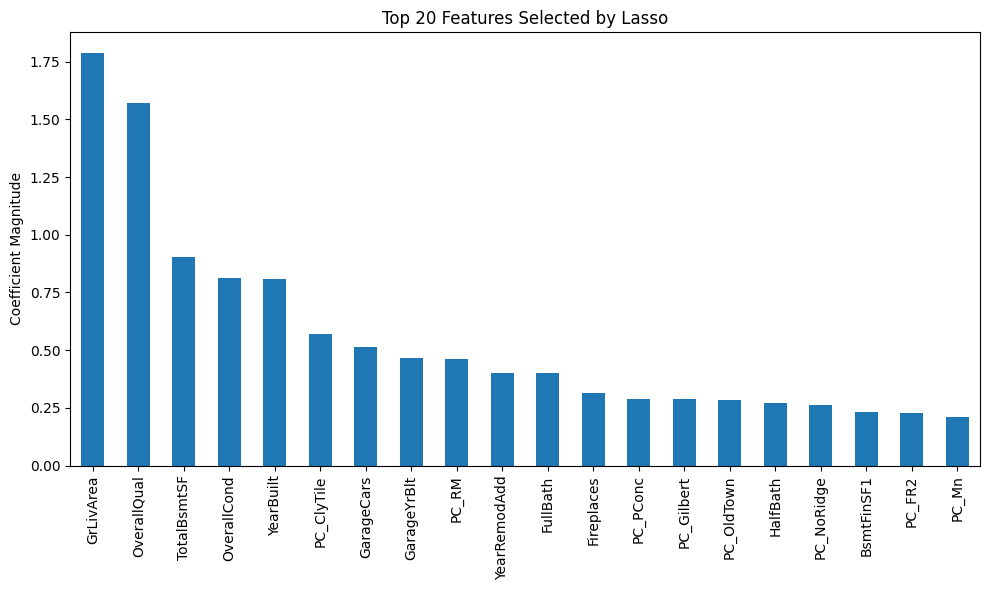

In [483]:
coef_abs = np.abs(lasso.coef_).max(axis=0)
lasso_coef_df = pd.Series(coef_abs, index=X_scaled_df.columns).sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
lasso_coef_df.plot(kind='bar')
plt.title('Top 20 Features Selected by Lasso')
plt.ylabel('Coefficient Magnitude')
plt.tight_layout()
plt.show()

### RFE (Further Refinement)

In [ ]:
# RFE Feature Selection
logreg = LogisticRegression(max_iter=5000, random_state=42)
rfe = RFE(estimator=logreg, n_features_to_select=20)
rfe.fit(X_scaled_df, y)

rfe_features = X_scaled_df.columns[rfe.get_support()]

#### Visualization: RFE Selected Features

In [ ]:
# Visualize RFE rankings
rfe_ranking_df = pd.Series(rfe.ranking_, index=X_scaled_df.columns).sort_values().head(20)

plt.figure(figsize=(10, 6))
rfe_ranking_df.plot(kind='bar')
plt.title('Top 20 Features by RFE Ranking (lower is better)')
plt.ylabel('Ranking')
plt.tight_layout()
plt.show()

### Further Refinement using Random Forest

In [376]:
# Random Forest Feature Selection
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled_df, y)

rf_importances = pd.Series(rf.feature_importances_, index=X_scaled_df.columns).sort_values(ascending=False).head(20)


#### Visualization: Feature importance using Random Forest

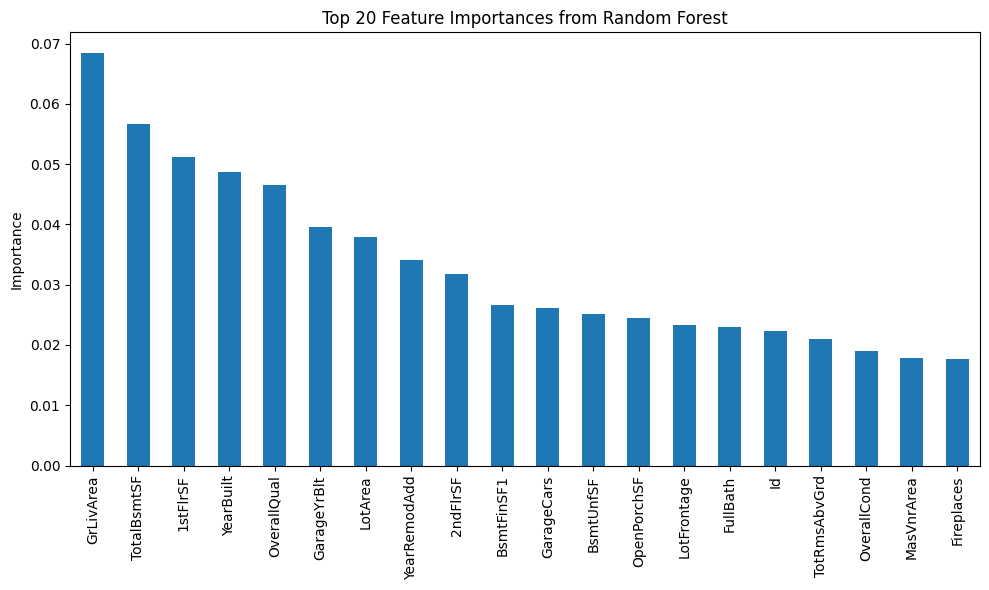

In [377]:
plt.figure(figsize=(10, 6))
rf_importances.plot(kind='bar')
plt.title('Top 20 Feature Importances from Random Forest')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

### Combine feature selection results

In [378]:
# Step 2: Combine features from Lasso, RFE, and Random Forest
combined_features = pd.concat([pd.Series(lasso_features), pd.Series(rfe_features), pd.Series(rf_importances.index)]).value_counts()

# Select features identified by at least two methods
final_features = combined_features[combined_features >= 2].index.tolist()

print(f'Total combined features selected: {len(final_features)}')
print('Final selected features:', final_features)

Total combined features selected: 25
Final selected features: ['OverallQual', 'LotArea', 'YearBuilt', 'OverallCond', 'YearRemodAdd', '1stFlrSF', 'TotalBsmtSF', 'BsmtFinSF1', 'Fireplaces', 'GarageCars', 'GrLivArea', 'Id', 'PC_Normal', 'MasVnrArea', 'KitchenAbvGr', 'FullBath', 'TotRmsAbvGrd', 'GarageYrBlt', 'PC_RM', 'OpenPorchSF', 'PC_Bnk', '2ndFlrSF', 'PC_PConc', 'PC_ClyTile', 'PC_New']


#### Visualization: Feature Selection with Combined Results

In [382]:
import plotly.express as px
import pandas as pd

# Convert the Series to DataFrame for Plotly
combined_features_df = combined_features.reset_index()
combined_features_df.columns = ['Feature', 'Frequency']
combined_features_df = combined_features_df.sort_values(by='Frequency', ascending=True)

# Plot using Plotly
fig = px.bar(
    combined_features_df,
    x='Frequency',
    y='Feature',
    orientation='h',
    title='Frequency of Features Selected by Lasso, RFE, and Random Forest',
    height=1600,  # Increase height for vertical scroll space
    width=900
)

fig.update_layout(
    yaxis=dict(
        tickfont=dict(size=10),
    ),
    xaxis=dict(title='Selection Frequency'),
    margin=dict(l=200, r=20, t=50, b=20)
)

fig.show()

### Refine DataFrame with Feature Selection

In [383]:
# Step 3: Refine dataframe to include only selected features for SVM RBF
X_final = X_scaled_df[final_features]